In [1]:
#http://ethen8181.github.io/machine-learning/clustering/GMM/GMM.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
%matplotlib inline

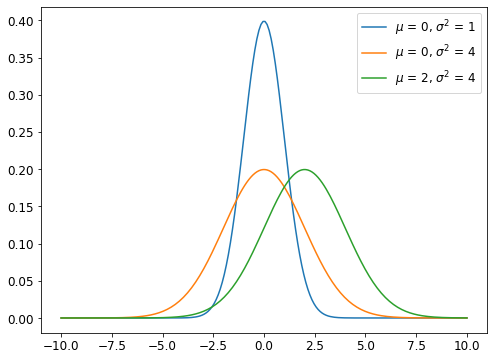

In [3]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# gaussian distribution with different values of the mean and variance
x = np.linspace(start = -10, stop = 10, num = 200)
mean_opt = [0, 0, 2]
var_opt = [1, 4, 4]

for m, v in zip(mean_opt, var_opt):
    y = norm(m, np.sqrt(v)).pdf(x)
    plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(m, v))
    plt.legend()

plt.show()

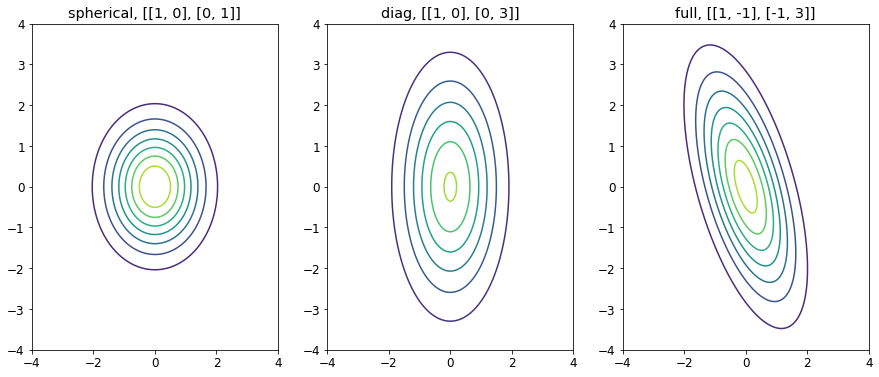

In [4]:
# revised from
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
x, y = np.mgrid[-4:4:.01, -4:4:.01]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y

# different values for the covariance matrix
covariances = [ [[1, 0], [0, 1]], [[1, 0], [0, 3]], [[1, -1], [-1, 3]] ]
titles = ['spherical', 'diag', 'full']

plt.figure(figsize = (15, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    z = multivariate_normal([0, 0], covariances[i]).pdf(position)
    plt.contour(x, y, z)
    plt.title('{}, {}'.format(titles[i], covariances[i]))
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plt.show()

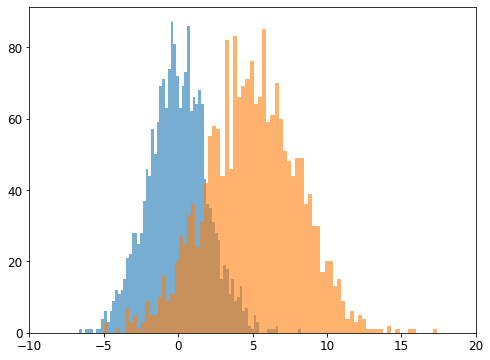

In [5]:
# generate some random data to work with
np.random.seed(2)
x1 = np.random.normal(0, 2, size = 2000)
x2 = np.random.normal(5, 3, size = 2000)
data = [x1, x2]

def plot_hist(data):
    for x in data:
        plt.hist(x, bins = 80,  alpha = 0.6)#normed = True,

    plt.xlim(-10, 20)

plot_hist(data)

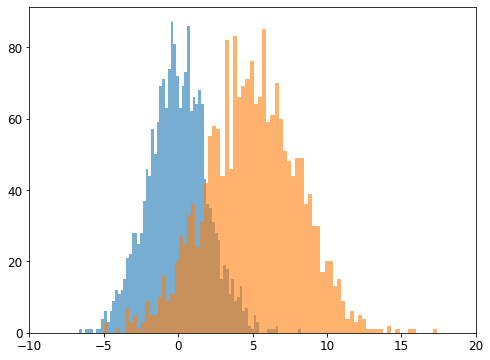

In [6]:
# estimate the mean and variance of the data
x1_mean, x1_var = np.mean(x1), np.var(x1)
x2_mean, x2_var = np.mean(x2), np.var(x2)
x_mean = [x1_mean, x2_mean]
x_var = [x1_var, x2_var]

def plot_guassian(x_mean, x_var):
    """
    note that scipy's normal distribution requires the
    standard deviation (square root of variance) 
    instead of the variance
    """
    x = np.linspace(start = -10, stop = 20, num = 200)
    for m, v in zip(x_mean, x_var):
        y = norm(m, np.sqrt(v)).pdf(x)
        plt.plot(x, y)

plot_hist(data)


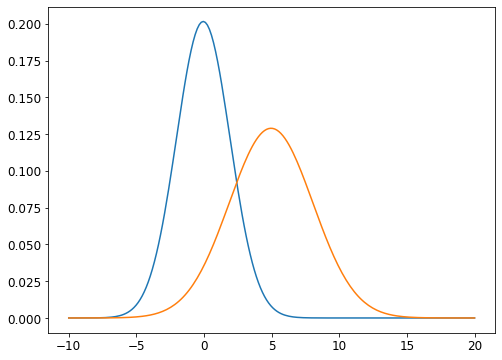

In [7]:
plot_guassian(x_mean, x_var)

In [8]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data

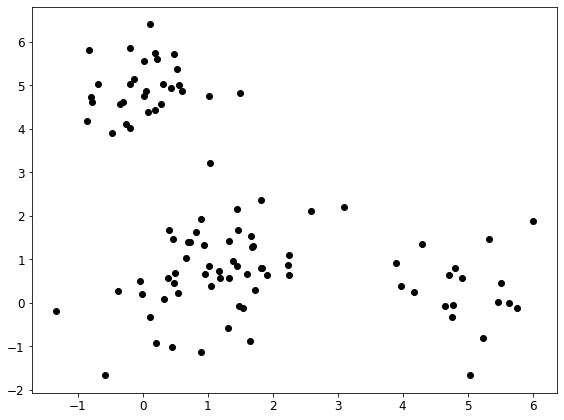

In [9]:
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [5, 0],
    [1, 1],
    [0, 5]
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]]
])

init_weights = [1 / 4, 1 / 2, 1 / 4]

# generate data
np.random.seed(4)
X = generate_data(100, init_means, init_covariances, init_weights)

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()


In [10]:
class GMM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization.

    Parameters
    ----------
    n_components : int
        Number of clusters/mixture components in which the data will be
        partitioned into.

    n_iters : int
        Maximum number of iterations to run the algorithm.

    tol : float
        Tolerance. If the log-likelihood between two iterations is smaller than
        the specified tolerance level, the algorithm will stop performing the
        EM optimization.

    seed : int
        Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components))

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""

        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self

In [11]:
def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])

    plt.title(title)
    plt.tight_layout()

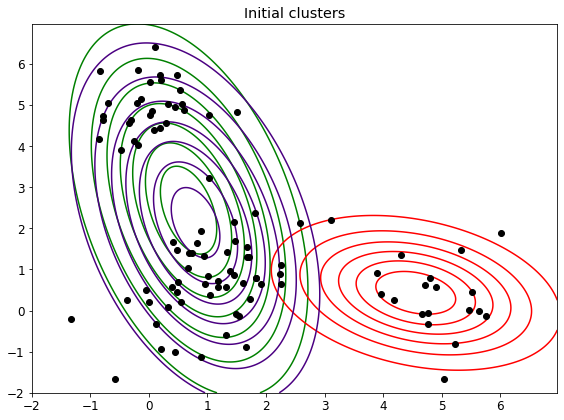

In [12]:
# use our implementation of the EM algorithm 
# and fit a mixture of Gaussians to the simulated data
gmm = GMM(n_components = 3, n_iters = 1, tol = 1e-4, seed = 4)
gmm.fit(X)

plot_contours(X, gmm.means, gmm.covs, 'Initial clusters')

converged iteration: 5


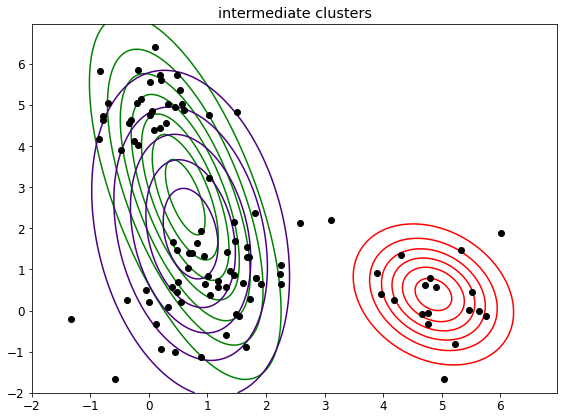

In [13]:
gmm = GMM(n_components = 3, n_iters = 5, tol = 1e-4, seed = 4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_contours(X, gmm.means, gmm.covs, 'intermediate clusters')

converged iteration: 10


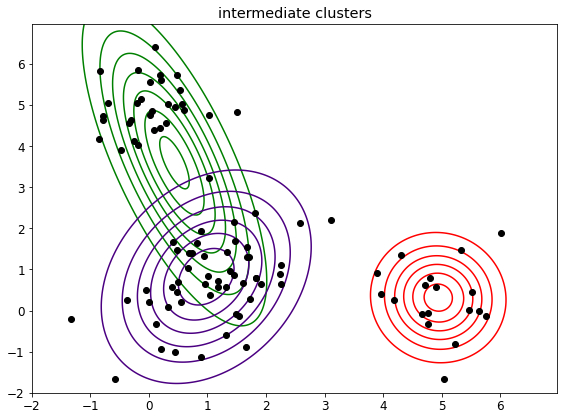

In [14]:
gmm = GMM(n_components = 3, n_iters = 10, tol = 1e-4, seed = 4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_contours(X, gmm.means, gmm.covs, 'intermediate clusters')

converged iteration: 15


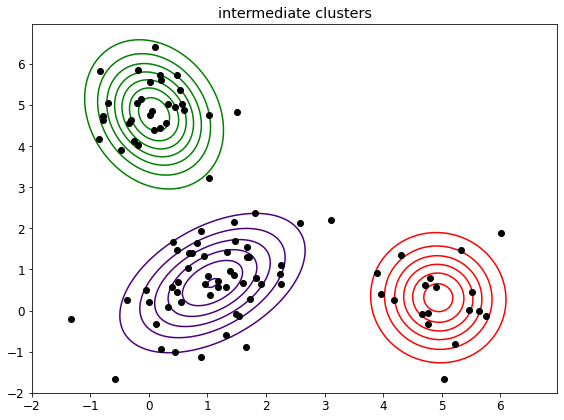

In [15]:
gmm = GMM(n_components = 3, n_iters = 15, tol = 1e-4, seed = 4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_contours(X, gmm.means, gmm.covs, 'intermediate clusters')

converged iteration: 20


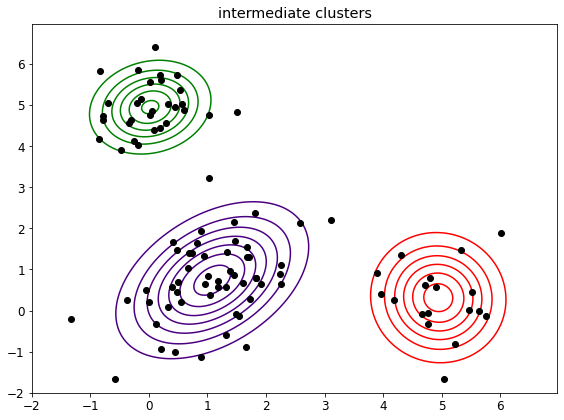

In [16]:
gmm = GMM(n_components = 3, n_iters = 20, tol = 1e-4, seed = 4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_contours(X, gmm.means, gmm.covs, 'intermediate clusters')

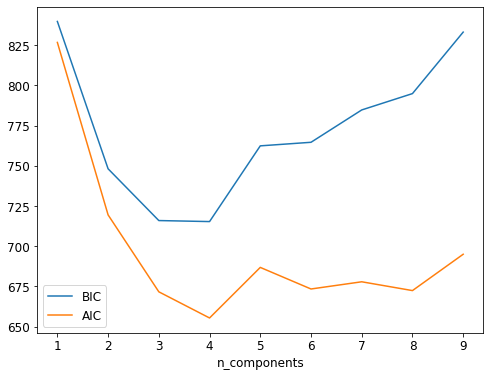

In [17]:
n_components = np.arange(1, 10)
clfs = [GaussianMixture(n, max_iter = 1000).fit(X) for n in n_components]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.plot(n_components, bics, label = 'BIC')
plt.plot(n_components, aics, label = 'AIC')
plt.xlabel('n_components')
plt.legend()
plt.show()